PRIVACY MODEL DEVELOPMENT

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
# Define file paths (Ensure you upload the datasets to Colab first)
file_paths = {
    "iot_device_logs": "/content/iot_device_logs.csv",
    "system_performance_logs": "/content/system_performance_logs.csv",
    "user_consent_data": "/content/user_consent_data.csv",
    "anomaly_data": "/content/anomaly_data.csv",
    "ehr_data": "/content/ehr_data.csv"
}

In [3]:
# Load datasets into pandas DataFrames
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

In [4]:
# Selecting relevant columns from each dataset
selected_columns = {
    "iot_device_logs": ["Timestamp", "Data_Sensitivity", "User_Interaction_Freq", "Network_Type",
                        "Bandwidth_Consumption_MB", "Anomalous_Activity"],
    "system_performance_logs": ["Timestamp", "Privacy_Score", "Response_Time_ms", "Blockchain_Latency_sec",
                                 "Data_Utility_Metric", "Error_Rates"],
    "user_consent_data": ["Consent_Timestamp", "Consent_Level", "Consent_Change_Frequency", "Behavioral_Trend"],
    "anomaly_data": ["Timestamp", "Access_Frequency_Deviation", "Failed_Login_Attempts", "Suspicious_Access_Location"],
    "ehr_data": ["Access_Timestamp", "Data_Classification", "Access_Role"]
}

In [5]:
# Extract only the selected columns
processed_datasets = {name: datasets[name][columns] for name, columns in selected_columns.items()}

In [6]:
# Renaming timestamp columns for consistency
processed_datasets["user_consent_data"].rename(columns={"Consent_Timestamp": "Timestamp"}, inplace=True)
processed_datasets["ehr_data"].rename(columns={"Access_Timestamp": "Timestamp"}, inplace=True)

<ipython-input-6-d50d83cd2ef3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_datasets["user_consent_data"].rename(columns={"Consent_Timestamp": "Timestamp"}, inplace=True)
<ipython-input-6-d50d83cd2ef3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_datasets["ehr_data"].rename(columns={"Access_Timestamp": "Timestamp"}, inplace=True)


In [7]:
# Merging all datasets on Timestamp using outer join to preserve all data
merged_data = processed_datasets["iot_device_logs"]
for name, df in processed_datasets.items():
    if name != "iot_device_logs":
        merged_data = pd.merge(merged_data, df, on="Timestamp", how="outer")

In [8]:
merged_data.head()

,Timestamp,Data_Sensitivity,User_Interaction_Freq,Network_Type,Bandwidth_Consumption_MB,Anomalous_Activity,Privacy_Score,Response_Time_ms,Blockchain_Latency_sec,Data_Utility_Metric,Error_Rates,Consent_Level,Consent_Change_Frequency,Behavioral_Trend,Access_Frequency_Deviation,Failed_Login_Attempts,Suspicious_Access_Location,Data_Classification,Access_Role
0,2024-01-01 01:00:00,Medium,9.0,Ethernet,4.642599,0.0,0.439668,246.0,1.530404,0.745046,4.032738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 01:00:00,Medium,20.0,WiFi,42.032969,0.0,0.439668,246.0,1.530404,0.745046,4.032738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 02:00:00,High,41.0,WiFi,20.327994,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.720427,7.0,0.0,NaN,NaN
4,2024-01-01 05:00:00,Low,2.0,WiFi,2.267589,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Handling missing values
for col in merged_data.select_dtypes(include=['number']).columns:
    merged_data[col].fillna(merged_data[col].median(), inplace=True)

for col in merged_data.select_dtypes(include=['object']).columns:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

<ipython-input-9-4866538a79ee>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data[col].fillna(merged_data[col].median(), inplace=True)
<ipython-input-9-4866538a79ee>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [10]:
# Encoding categorical variables
label_encoders = {}
for col in merged_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merged_data[col] = le.fit_transform(merged_data[col])
    label_encoders[col] = le

In [11]:
# Normalizing numerical features
scaler = StandardScaler()
numerical_cols = merged_data.select_dtypes(include=['number']).columns.difference(['Anomalous_Activity'])
merged_data[numerical_cols] = scaler.fit_transform(merged_data[numerical_cols])

In [12]:
merged_data.head()

,Timestamp,Data_Sensitivity,User_Interaction_Freq,Network_Type,Bandwidth_Consumption_MB,Anomalous_Activity,Privacy_Score,Response_Time_ms,Blockchain_Latency_sec,Data_Utility_Metric,Error_Rates,Consent_Level,Consent_Change_Frequency,Behavioral_Trend,Access_Frequency_Deviation,Failed_Login_Attempts,Suspicious_Access_Location,Data_Classification,Access_Role
0,-1.728954,2.321430,-1.887323,0.904350,-2.156767,0.0,-0.099320,-1.227241,-2.365362,-0.154077,2.631167,-0.293851,-0.034581,0.360591,0.024205,0.064842,-0.365931,0.404817,0.495439
1,-1.728954,2.321430,-0.650249,2.350654,1.997586,0.0,-0.099320,-1.227241,-2.365362,-0.154077,2.631167,-0.293851,-0.034581,0.360591,0.024205,0.064842,-0.365931,0.404817,0.495439
2,-1.726000,-0.535216,1.711437,2.350654,-0.414001,1.0,-0.049044,0.065539,-0.003261,-0.006624,0.010684,-0.293851,-0.034581,0.360591,0.024205,0.064842,-0.365931,0.404817,0.495439
3,-1.723045,-0.535216,0.024518,-0.541953,-0.024024,0.0,-0.049044,0.065539,-0.003261,-0.006624,0.010684,-0.293851,-0.034581,0.360591,1.653048,1.446403,-0.365931,0.404817,0.495439
4,-1.720091,0.893107,-2.674552,2.350654,-2.420649,0.0,-0.049044,0.065539,-0.003261,-0.006624,0.010684,-0.293851,-0.034581,0.360591,0.024205,0.064842,-0.365931,0.404817,0.495439


In [13]:
# Splitting data into training and test sets
X = merged_data.drop(columns=['Anomalous_Activity'])
y = merged_data['Anomalous_Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, use_label_encoder=False, eval_metric="logloss")

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [0, 1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
560 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 25}


RandomForestClassifier(min_samples_split=5, n_estimators=25, random_state=42)

In [17]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [18]:
# Evaluate performance
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

F1 Score: 0.5319
Precision: 0.5952
Recall: 0.4808
ROC AUC: 0.8978


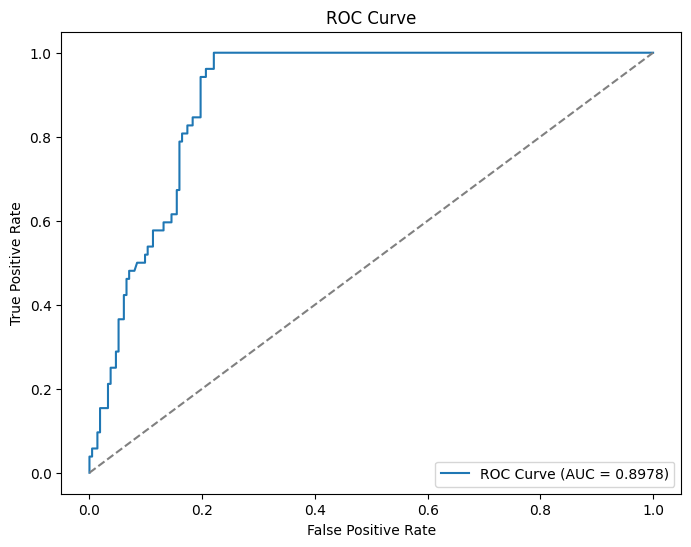

In [19]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve



In [21]:
# ✅ Load preprocessed dataset (Ensure this step is done)
# Assume `merged_data` is already preprocessed and available
X = merged_data.drop(columns=['Anomalous_Activity'])
y = merged_data['Anomalous_Activity']

In [22]:
# ✅ Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# ✅ Define optimized hyperparameter grid (Fixed Errors)
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # More trees improve stability
    'max_depth': [None, 10, 15, 20],  # Keep None for unlimited depth
    'min_samples_split': [2, 5, 10],  # Avoid 1 (invalid value)
    'min_samples_leaf': [1, 2, 4],  # Avoid 0 (invalid value)
    'max_features': ['sqrt', 'log2'],  # Control feature selection like XGBoost
    'bootstrap': [True, False]  # Test both sampling techniques
}

In [24]:
# ✅ Define the Random Forest model with class weight for imbalanced data
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)

In [25]:
# ✅ Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    rf_model, param_grid, cv=5, n_iter=30, scoring='f1', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300,
                                                         500]},
                   random_state=42, scoring='f1')

In [26]:
# ✅ Get best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


In [27]:
# ✅ Train the best model with optimal parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=300,
                       random_state=42)

In [28]:
# ✅ Make predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Probability for positive class

In [29]:
# ✅ Evaluate performance
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

F1 Score: 0.4719
Precision: 0.5676
Recall: 0.4038
ROC AUC: 0.8971


In [30]:
# ✅ Feature Importance Analysis (Drop less important features)
importances = best_rf.feature_importances_
feature_names = X_train.columns

In [31]:
# Sort by importance
sorted_indices = np.argsort(importances)[::-1]

In [32]:
# Display top 10 features
print("\nTop 10 Most Important Features:")
for idx in sorted_indices[:10]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top 10 Most Important Features:
Bandwidth_Consumption_MB: 0.2845
User_Interaction_Freq: 0.2572
Network_Type: 0.1525
Data_Sensitivity: 0.1318
Timestamp: 0.0800
Consent_Change_Frequency: 0.0156
Access_Role: 0.0152
Failed_Login_Attempts: 0.0094
Access_Frequency_Deviation: 0.0091
Data_Utility_Metric: 0.0066


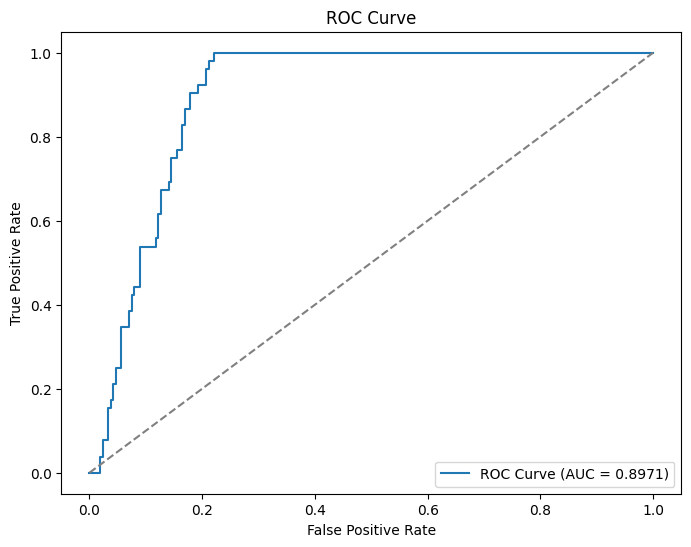

In [33]:
# ✅ Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}

🔥 Model Performance with 10 Features 🔥
F1 Score: 0.5941
Precision: 0.6122
Recall: 0.5769
ROC AUC: 0.8987


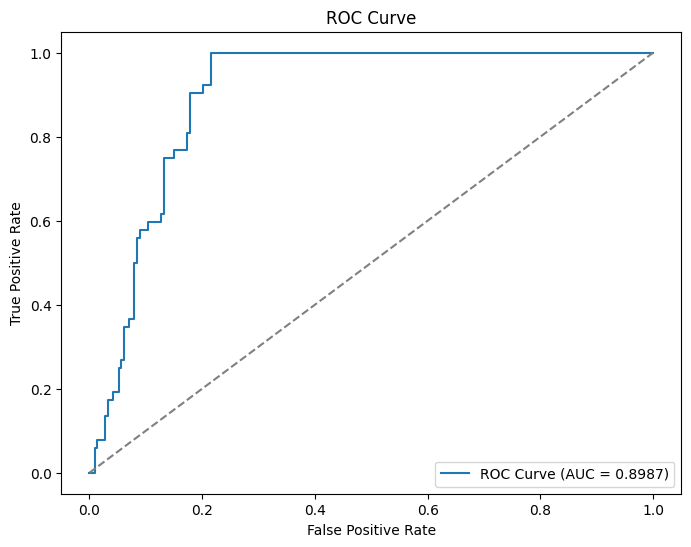

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve

# ✅ Step 1: Select only the top 10 features + target variable
selected_features = [
    "Bandwidth_Consumption_MB", "User_Interaction_Freq", "Network_Type",
    "Data_Sensitivity", "Timestamp", "Consent_Change_Frequency",
    "Access_Role", "Failed_Login_Attempts", "Access_Frequency_Deviation",
    "Data_Utility_Metric"
]

# ✅ Create a new dataset with only the selected features
X_selected = merged_data[selected_features]
y = merged_data["Anomalous_Activity"]  # Target variable remains the same

# ✅ Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Define optimized hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],  # More trees improve stability
    'max_depth': [None, 10, 15, 20],  # Keep None for unlimited depth
    'min_samples_split': [2, 5, 10],  # Avoid 1 (invalid value)
    'min_samples_leaf': [1, 2, 4],  # Avoid 0 (invalid value)
    'max_features': ['sqrt', 'log2'],  # Control feature selection like XGBoost
    'bootstrap': [True, False]  # Test both sampling techniques
}

# ✅ Define the Random Forest model with class weight for imbalanced data
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)

# ✅ Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    rf_model, param_grid, cv=5, n_iter=30, scoring='f1', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

# ✅ Get best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# ✅ Train the best model with optimal parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# ✅ Make predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Probability for positive class

# ✅ Evaluate performance
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n🔥 Model Performance with 10 Features 🔥")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ✅ Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [35]:
#!pip uninstall -y xgboost scikit-learn
#!pip install --upgrade xgboost scikit-learn

In [36]:
import xgboost
import sklearn

print("XGBoost Version:", xgboost.__version__)
print("Scikit-Learn Version:", sklearn.__version__)


XGBoost Version: 1.6.2
Scikit-Learn Version: 1.2.2


In [37]:
!pip install xgboost==1.6.2 scikit-learn==1.2.2

In [38]:
!pip uninstall -y imbalanced-learn
!pip install imbalanced-learn==0.10.1

Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


70-30 SPLIT After fine tuning

Optimal Decision Threshold: 0.8571

🔥 Model Performance with RF + Extra Trees 🔥
F1 Score: 0.9679
Precision: 0.9902
Recall: 0.9467
ROC AUC: 0.9914


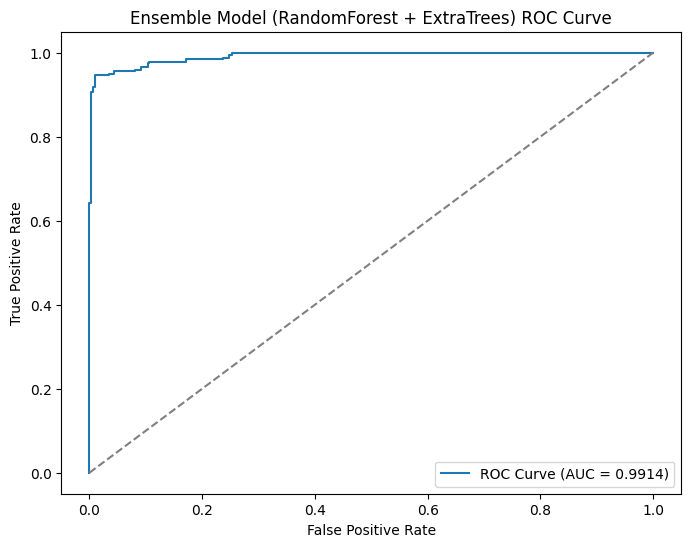

In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ✅ Step 1: Select only the top 10 features + target variable
selected_features = [
    "Bandwidth_Consumption_MB", "User_Interaction_Freq", "Network_Type",
    "Data_Sensitivity", "Timestamp", "Consent_Change_Frequency",
    "Access_Role", "Failed_Login_Attempts", "Access_Frequency_Deviation",
    "Data_Utility_Metric"
]

# ✅ Create a new dataset with only the selected features
X_selected = merged_data[selected_features]
y = merged_data["Anomalous_Activity"]  # Target variable remains the same

# ✅ Step 2: Handle Class Imbalance using Random Oversampling instead of SMOTE
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_selected, y)

# ✅ Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# ✅ Step 4: Feature Engineering (Adding Interaction Terms)
X_train["Bandwidth_User_Freq"] = X_train["Bandwidth_Consumption_MB"] * X_train["User_Interaction_Freq"]
X_test["Bandwidth_User_Freq"] = X_test["Bandwidth_Consumption_MB"] * X_test["User_Interaction_Freq"]

# ✅ Step 5: Define hyperparameter grid for both models
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_grid_et = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# ✅ Step 6: Define and Tune Random Forest Model
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
random_search_rf = RandomizedSearchCV(rf_model, param_grid_rf, cv=5, n_iter=30, scoring='f1', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# ✅ Step 7: Define and Tune Extra Trees Model
et_model = ExtraTreesClassifier(class_weight="balanced", random_state=42)
random_search_et = RandomizedSearchCV(et_model, param_grid_et, cv=5, n_iter=30, scoring='f1', n_jobs=-1, random_state=42)
random_search_et.fit(X_train, y_train)
best_et = ExtraTreesClassifier(**random_search_et.best_params_, random_state=42)
best_et.fit(X_train, y_train)

# ✅ Step 8: Ensemble Model (Voting Classifier with RandomForest + ExtraTrees)
ensemble_model = VotingClassifier(
    estimators=[('RandomForest', best_rf), ('ExtraTrees', best_et)],
    voting='soft'  # Soft voting averages the predicted probabilities
)
ensemble_model.fit(X_train, y_train)

# ✅ Step 9: Make Predictions with Ensemble Model
y_pred = ensemble_model.predict(X_test)
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# ✅ Step 10: Tune Decision Threshold (Optimize Precision vs. Recall)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find the best threshold that balances precision and recall
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
print(f"Optimal Decision Threshold: {best_threshold:.4f}")

# Make predictions using the optimized threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# ✅ Step 11: Evaluate Performance
f1 = f1_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n🔥 Model Performance with RF + Extra Trees 🔥")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ✅ Step 12: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model (RandomForest + ExtraTrees) ROC Curve')
plt.legend()
plt.show()


80-20 SPLIT before fine tuning

Optimal Decision Threshold: 0.7723

🔥 Model Performance with RF + Extra Trees 🔥
F1 Score: 0.9812
Precision: 0.9812
Recall: 0.9812
ROC AUC: 0.9976


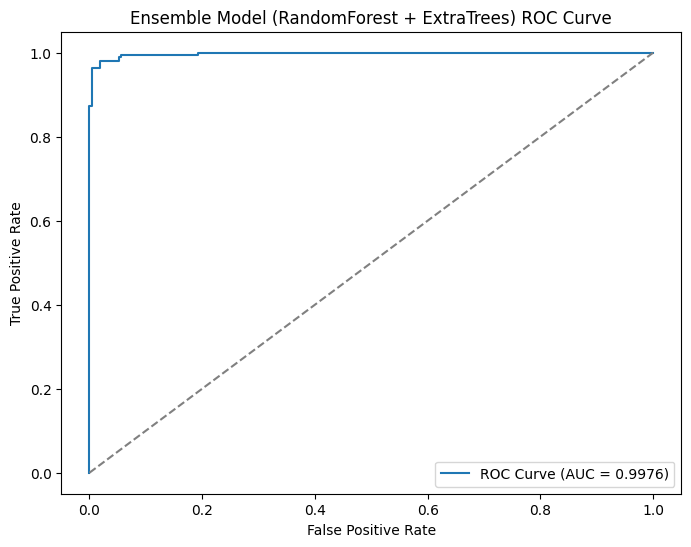

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ✅ Step 1: Select only the top 10 features + target variable
selected_features = [
    "Bandwidth_Consumption_MB", "User_Interaction_Freq", "Network_Type",
    "Data_Sensitivity", "Timestamp", "Consent_Change_Frequency",
    "Access_Role", "Failed_Login_Attempts", "Access_Frequency_Deviation",
    "Data_Utility_Metric"
]

# ✅ Create a new dataset with only the selected features
X_selected = merged_data[selected_features]
y = merged_data["Anomalous_Activity"]  # Target variable remains the same

# ✅ Step 2: Handle Class Imbalance using Random Oversampling instead of SMOTE
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_selected, y)

# ✅ Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Step 4: Feature Engineering (Adding Interaction Terms)
X_train["Bandwidth_User_Freq"] = X_train["Bandwidth_Consumption_MB"] * X_train["User_Interaction_Freq"]
X_test["Bandwidth_User_Freq"] = X_test["Bandwidth_Consumption_MB"] * X_test["User_Interaction_Freq"]

# ✅ Step 5: Define hyperparameter grid for both models
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_grid_et = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# ✅ Step 6: Define and Tune Random Forest Model
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
random_search_rf = RandomizedSearchCV(rf_model, param_grid_rf, cv=5, n_iter=30, scoring='f1', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# ✅ Step 7: Define and Tune Extra Trees Model
et_model = ExtraTreesClassifier(class_weight="balanced", random_state=42)
random_search_et = RandomizedSearchCV(et_model, param_grid_et, cv=5, n_iter=30, scoring='f1', n_jobs=-1, random_state=42)
random_search_et.fit(X_train, y_train)
best_et = ExtraTreesClassifier(**random_search_et.best_params_, random_state=42)
best_et.fit(X_train, y_train)

# ✅ Step 8: Ensemble Model (Voting Classifier with RandomForest + ExtraTrees)
ensemble_model = VotingClassifier(
    estimators=[('RandomForest', best_rf), ('ExtraTrees', best_et)],
    voting='soft'  # Soft voting averages the predicted probabilities
)
ensemble_model.fit(X_train, y_train)

# ✅ Step 9: Make Predictions with Ensemble Model
y_pred = ensemble_model.predict(X_test)
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# ✅ Step 10: Tune Decision Threshold (Optimize Precision vs. Recall)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find the best threshold that balances precision and recall
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
print(f"Optimal Decision Threshold: {best_threshold:.4f}")

# Make predictions using the optimized threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# ✅ Step 11: Evaluate Performance
f1 = f1_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n🔥 Model Performance with RF + Extra Trees 🔥")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ✅ Step 12: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model (RandomForest + ExtraTrees) ROC Curve')
plt.legend()
plt.show()


70-30 SPLIT After fine tuning

Cross-Validation F1 Score (Mean): 0.8984
Optimal Decision Threshold: 0.6853

🔥 Model Performance After Fine-Tuning 🔥
Cross-Validation F1 Score: 0.8984
F1 Score: 0.9069
Precision: 0.8703
Recall: 0.9467
ROC AUC: 0.9694


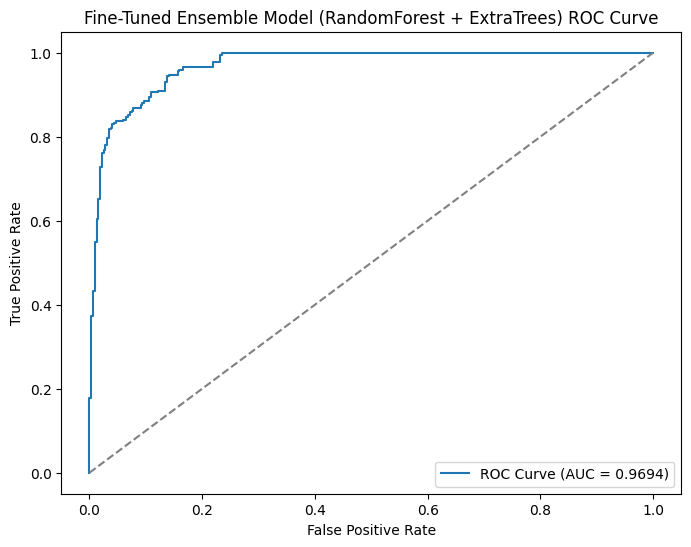

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ✅ Step 1: Select only the top features + target variable (Refining Feature Selection)
selected_features = [
    "Bandwidth_Consumption_MB", "User_Interaction_Freq", "Network_Type",
    "Data_Sensitivity", "Timestamp", "Consent_Change_Frequency",
    "Access_Role", "Failed_Login_Attempts"
]  # Removed 2 lowest-ranked features

# ✅ Create a new dataset with only the selected features
X_selected = merged_data[selected_features]
y = merged_data["Anomalous_Activity"]  # Target variable remains the same

# ✅ Step 2: Handle Class Imbalance using Random Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_selected, y)

# ✅ Step 3: Split into training and test sets (More Generalization)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# ✅ Step 4: Feature Engineering (Adding Interaction Terms)
X_train["Bandwidth_User_Freq"] = X_train["Bandwidth_Consumption_MB"] * X_train["User_Interaction_Freq"]
X_test["Bandwidth_User_Freq"] = X_test["Bandwidth_Consumption_MB"] * X_test["User_Interaction_Freq"]

# ✅ Step 5: Define hyperparameter grid for Random Forest & Extra Trees (Refined)
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Kept reasonable values
    'max_depth': [10, 15, 20],  # Limited depth to prevent overfitting
    'min_samples_split': [5, 10],  # Reducing unnecessary splits
    'min_samples_leaf': [2, 4],  # Prevents too small leaf nodes
    'max_features': ['sqrt'],  # Consistent feature selection
    'bootstrap': [True]
}

param_grid_et = param_grid_rf  # Same settings for Extra Trees

# ✅ Step 6: Define and Tune Random Forest Model with K-Fold Cross-Validation (cv=10)
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
random_search_rf = RandomizedSearchCV(rf_model, param_grid_rf, cv=10, n_iter=20, scoring='f1', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# ✅ Step 7: Define and Tune Extra Trees Model with K-Fold Cross-Validation
et_model = ExtraTreesClassifier(class_weight="balanced", random_state=42)
random_search_et = RandomizedSearchCV(et_model, param_grid_et, cv=10, n_iter=20, scoring='f1', n_jobs=-1, random_state=42)
random_search_et.fit(X_train, y_train)
best_et = ExtraTreesClassifier(**random_search_et.best_params_, random_state=42)
best_et.fit(X_train, y_train)

# ✅ Step 8: Ensemble Model (Voting Classifier with Soft Voting)
ensemble_model = VotingClassifier(
    estimators=[('RandomForest', best_rf), ('ExtraTrees', best_et)],
    voting='soft'  # Soft voting averages predicted probabilities
)
ensemble_model.fit(X_train, y_train)

# ✅ Step 9: Evaluate Model with K-Fold Cross-Validation (Ensures Generalization)
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=10, scoring='f1')
print(f"Cross-Validation F1 Score (Mean): {np.mean(cv_scores):.4f}")

# ✅ Step 10: Make Predictions with Ensemble Model
y_pred = ensemble_model.predict(X_test)
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# ✅ Step 11: Tune Decision Threshold (Optimize Precision vs. Recall)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
print(f"Optimal Decision Threshold: {best_threshold:.4f}")

# Make predictions using the optimized threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# ✅ Step 12: Evaluate Performance (After Fine-Tuning)
f1 = f1_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n🔥 Model Performance After Fine-Tuning 🔥")
print(f"Cross-Validation F1 Score: {np.mean(cv_scores):.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ✅ Step 13: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fine-Tuned Ensemble Model (RandomForest + ExtraTrees) ROC Curve')
plt.legend()
plt.show()


80-20 SPLIT After fine tuning

Cross-Validation F1 Score (Mean): 0.8987
Optimal Decision Threshold: 0.6930

🔥 Model Performance After Fine-Tuning 🔥
Cross-Validation F1 Score: 0.8987
F1 Score: 0.9406
Precision: 0.9156
Recall: 0.9671
ROC AUC: 0.9855


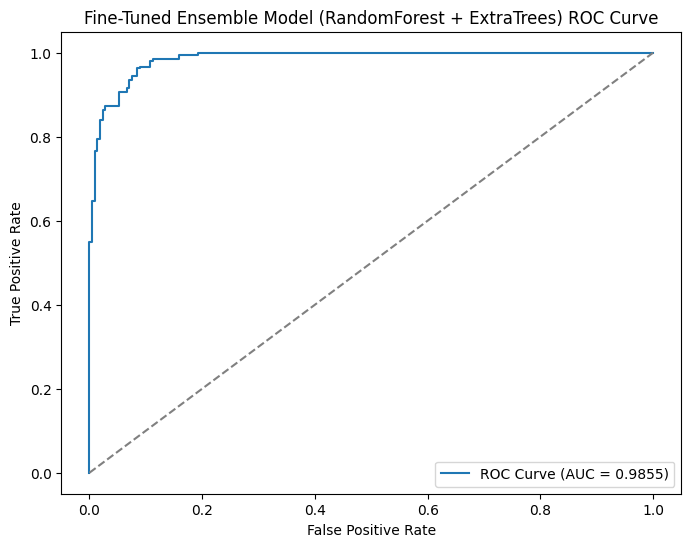

In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ✅ Step 1: Select only the top features + target variable (Refining Feature Selection)
selected_features = [
    "Bandwidth_Consumption_MB", "User_Interaction_Freq", "Network_Type",
    "Data_Sensitivity", "Timestamp", "Consent_Change_Frequency",
    "Access_Role", "Failed_Login_Attempts"
]  # Removed 2 lowest-ranked features

# ✅ Create a new dataset with only the selected features
X_selected = merged_data[selected_features]
y = merged_data["Anomalous_Activity"]  # Target variable remains the same

# ✅ Step 2: Handle Class Imbalance using Random Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_selected, y)

# ✅ Step 3: Split into training and test sets (More Generalization)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ✅ Step 4: Feature Engineering (Adding Interaction Terms)
X_train["Bandwidth_User_Freq"] = X_train["Bandwidth_Consumption_MB"] * X_train["User_Interaction_Freq"]
X_test["Bandwidth_User_Freq"] = X_test["Bandwidth_Consumption_MB"] * X_test["User_Interaction_Freq"]

# ✅ Step 5: Define hyperparameter grid for Random Forest & Extra Trees (Refined)
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Kept reasonable values
    'max_depth': [10, 15, 20],  # Limited depth to prevent overfitting
    'min_samples_split': [5, 10],  # Reducing unnecessary splits
    'min_samples_leaf': [2, 4],  # Prevents too small leaf nodes
    'max_features': ['sqrt'],  # Consistent feature selection
    'bootstrap': [True]
}

param_grid_et = param_grid_rf  # Same settings for Extra Trees

# ✅ Step 6: Define and Tune Random Forest Model with K-Fold Cross-Validation (cv=10)
rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
random_search_rf = RandomizedSearchCV(rf_model, param_grid_rf, cv=10, n_iter=20, scoring='f1', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)
best_rf = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# ✅ Step 7: Define and Tune Extra Trees Model with K-Fold Cross-Validation
et_model = ExtraTreesClassifier(class_weight="balanced", random_state=42)
random_search_et = RandomizedSearchCV(et_model, param_grid_et, cv=10, n_iter=20, scoring='f1', n_jobs=-1, random_state=42)
random_search_et.fit(X_train, y_train)
best_et = ExtraTreesClassifier(**random_search_et.best_params_, random_state=42)
best_et.fit(X_train, y_train)

# ✅ Step 8: Ensemble Model (Voting Classifier with Soft Voting)
ensemble_model = VotingClassifier(
    estimators=[('RandomForest', best_rf), ('ExtraTrees', best_et)],
    voting='soft'  # Soft voting averages predicted probabilities
)
ensemble_model.fit(X_train, y_train)

# ✅ Step 9: Evaluate Model with K-Fold Cross-Validation (Ensures Generalization)
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=10, scoring='f1')
print(f"Cross-Validation F1 Score (Mean): {np.mean(cv_scores):.4f}")

# ✅ Step 10: Make Predictions with Ensemble Model
y_pred = ensemble_model.predict(X_test)
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]

# ✅ Step 11: Tune Decision Threshold (Optimize Precision vs. Recall)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]
print(f"Optimal Decision Threshold: {best_threshold:.4f}")

# Make predictions using the optimized threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

# ✅ Step 12: Evaluate Performance (After Fine-Tuning)
f1 = f1_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n🔥 Model Performance After Fine-Tuning 🔥")
print(f"Cross-Validation F1 Score: {np.mean(cv_scores):.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ✅ Step 13: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fine-Tuned Ensemble Model (RandomForest + ExtraTrees) ROC Curve')
plt.legend()
plt.show()


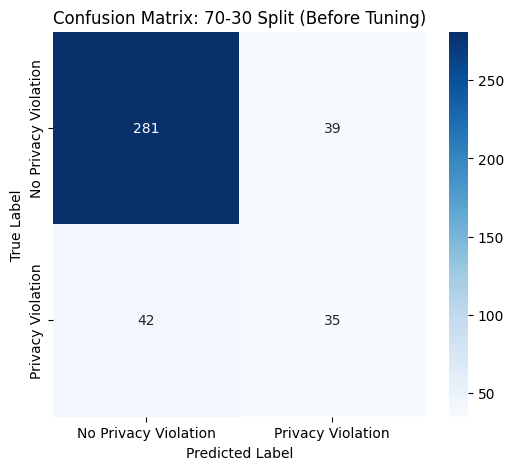

In [43]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split Data (70-30)
X_train_7030, X_test_7030, y_train_7030, y_test_7030 = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# Define base models
rf_7030 = RandomForestClassifier(random_state=42)
et_7030 = ExtraTreesClassifier(random_state=42)

# Train the models
rf_7030.fit(X_train_7030, y_train_7030)
et_7030.fit(X_train_7030, y_train_7030)

# Create ensemble model
ensemble_7030 = VotingClassifier(estimators=[('RandomForest', rf_7030), ('ExtraTrees', et_7030)], voting='soft')
ensemble_7030.fit(X_train_7030, y_train_7030)

# Make Predictions
y_pred_7030 = ensemble_7030.predict(X_test_7030)

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Privacy Violation", "Privacy Violation"],
                yticklabels=["No Privacy Violation", "Privacy Violation"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test_7030, y_pred_7030, "Confusion Matrix: 70-30 Split (Before Tuning)")


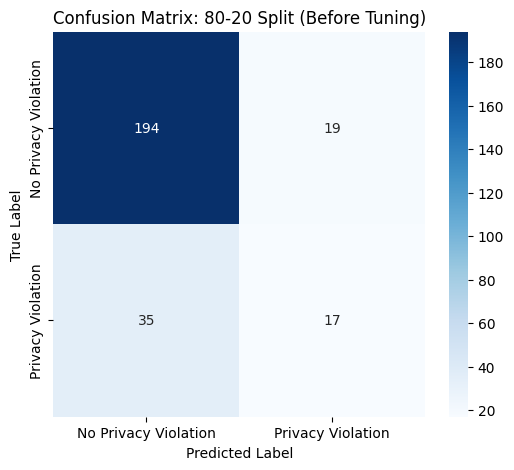

In [44]:
# Split Data (80-20)
X_train_8020, X_test_8020, y_train_8020, y_test_8020 = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Define base models
rf_8020 = RandomForestClassifier(random_state=42)
et_8020 = ExtraTreesClassifier(random_state=42)

# Train the models
rf_8020.fit(X_train_8020, y_train_8020)
et_8020.fit(X_train_8020, y_train_8020)

# Create ensemble model
ensemble_8020 = VotingClassifier(estimators=[('RandomForest', rf_8020), ('ExtraTrees', et_8020)], voting='soft')
ensemble_8020.fit(X_train_8020, y_train_8020)

# Make Predictions
y_pred_8020 = ensemble_8020.predict(X_test_8020)

# Plot Confusion Matrix
plot_confusion_matrix(y_test_8020, y_pred_8020, "Confusion Matrix: 80-20 Split (Before Tuning)")


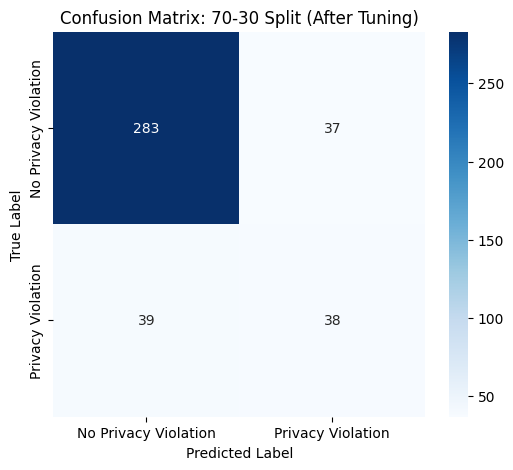

In [45]:
# Define hyperparameter-tuned models
best_rf_7030 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10, min_samples_leaf=4,
                                      max_features='log2', bootstrap=True, random_state=42)

best_et_7030 = ExtraTreesClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2,
                                    max_features='sqrt', bootstrap=False, random_state=42)

# Train the fine-tuned models
best_rf_7030.fit(X_train_7030, y_train_7030)
best_et_7030.fit(X_train_7030, y_train_7030)

# Create fine-tuned ensemble model
ensemble_7030_tuned = VotingClassifier(estimators=[('RandomForest', best_rf_7030), ('ExtraTrees', best_et_7030)], voting='soft')
ensemble_7030_tuned.fit(X_train_7030, y_train_7030)

# Make Predictions
y_pred_7030_tuned = ensemble_7030_tuned.predict(X_test_7030)

# Plot Confusion Matrix
plot_confusion_matrix(y_test_7030, y_pred_7030_tuned, "Confusion Matrix: 70-30 Split (After Tuning)")


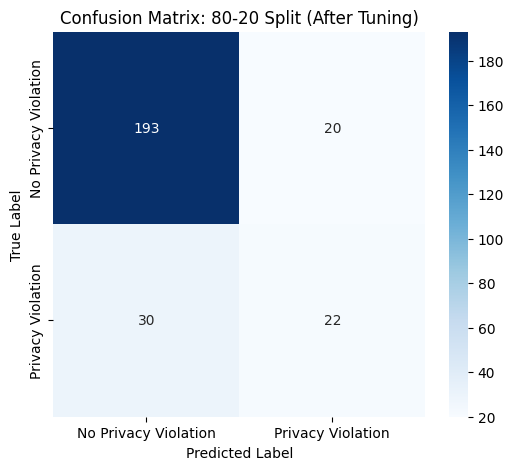

In [46]:
# Define hyperparameter-tuned models
best_rf_8020 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10, min_samples_leaf=4,
                                      max_features='log2', bootstrap=True, random_state=42)

best_et_8020 = ExtraTreesClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2,
                                    max_features='sqrt', bootstrap=False, random_state=42)

# Train the fine-tuned models
best_rf_8020.fit(X_train_8020, y_train_8020)
best_et_8020.fit(X_train_8020, y_train_8020)

# Create fine-tuned ensemble model
ensemble_8020_tuned = VotingClassifier(estimators=[('RandomForest', best_rf_8020), ('ExtraTrees', best_et_8020)], voting='soft')
ensemble_8020_tuned.fit(X_train_8020, y_train_8020)

# Make Predictions
y_pred_8020_tuned = ensemble_8020_tuned.predict(X_test_8020)

# Plot Confusion Matrix
plot_confusion_matrix(y_test_8020, y_pred_8020_tuned, "Confusion Matrix: 80-20 Split (After Tuning)")
